In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, date, timedelta, timezone
import pandas as pd
import numpy as np
import random
import warnings
warnings.simplefilter('ignore')
from scipy.stats import linregress

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Iterable, Tuple

import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

try:
    from hmmlearn.hmm import GaussianHMM
except ImportError:
    GaussianHMM = None  # type: ignore

import matplotlib.pyplot as plt

def log_ret(s):                # daily log-return
    return np.log(s/ s.shift(1))

In [2]:
file_path = "list.xlsx"
sheet_name = "US"  # Replace with your sheet name or use None for the first sheet

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

In [7]:
# needs to be more precision

lengths = []
Y = np.array([[0,0,0,0,0,0]])

for t in df["Symbol"]:
    data = yf.Ticker(t) #PEP, KO er utroligt stabile. NOVAQ, BAC er utroligt ustabil
    data = data.history(start = "1996-01-01", end = "2025-08-15")
    data = data.reset_index(drop = True)
    
    data = data[["Open", "High", "Low", "Close", "Volume"]]
    
    data['log returns'] = log_ret(data['Close'])

    data['ma20'] = data['Close'].rolling(window=20).mean()
    data['ma40'] = data['Close'].rolling(window=40).mean()
    data['ma120']= data['Close'].rolling(window=120).mean()

    # Compute MACD line and Signal line
    data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
    data['EMA40']  = data['Close'].ewm(span=40, adjust=False).mean()
    data['EMA120']  = data['Close'].ewm(span=120, adjust=False).mean()

    data["sma-s"] = np.sign(data["Close"] - data["ma20"])
    data["mma-s"] = np.sign(data["Close"] - data["ma40"])
    data["lma-s"] = np.sign(data["Close"] - data["ma120"])

    data["sEma-s"] = np.sign(data["Close"] - data['EMA20'])
    data["mEma-s"] = np.sign(data["Close"] - data["EMA40"])
    data["lEma-s"] = np.sign(data["Close"] - data["EMA120"])

    #features needed 
    features = data[["sma-s","mma-s","lma-s", "sEma-s", "mEma-s", "lEma-s"]][1000:]
    features = features.reset_index(drop = True)
    
    X = np.array(features)
    Y = np.concatenate([Y, X])
        
    lengths.append(len(features))

Y = Y[1:]


$AACIW: possibly delisted; no price data found  (1d 1996-01-01 -> 2025-08-15)
$AADI: possibly delisted; no timezone found
$AAGRW: possibly delisted; no price data found  (1d 1996-01-01 -> 2025-08-15)
$AAMC: possibly delisted; no timezone found
$AAN: possibly delisted; no timezone found
$ABIO: possibly delisted; no timezone found
$ABLLW: possibly delisted; no price data found  (1d 1996-01-01 -> 2025-08-15)
$ABR^D: possibly delisted; no timezone found
$ABR^E: possibly delisted; no timezone found
$ABR^F: possibly delisted; no timezone found
$ACAB: possibly delisted; no timezone found
$ACABW: possibly delisted; no timezone found
$ACACU: possibly delisted; no timezone found
$ACACW: possibly delisted; no timezone found
$ACCD: possibly delisted; no timezone found
$ACONW: possibly delisted; no price data found  (1d 1996-01-01 -> 2025-08-15)
$ACP^A: possibly delisted; no timezone found
$ACR^C: possibly delisted; no timezone found
$ACR^D: possibly delisted; no timezone found
$ADC^A: possibly del

IndexError: index 0 is out of bounds for axis 0 with size 0

In [17]:
l = []
for i in range(len(lengths)):
    if lengths[i] != 0:
        l.append(lengths[i])

In [20]:
pp_model = GaussianHMM(n_components=3,covariance_type="full",n_iter=1000,random_state=3)
pp_model.fit(Y, lengths = l)

import pickle
from hmmlearn import hmm

# Assume `model` is your fitted HMM
# Save the model
with open("price.pkl", "wb") as f:
    pickle.dump(pp_model, f)

Model is not converging.  Current: 257727279.3076091 is not greater than 264411440.36255866. Delta is -6684161.054949552


NameError: name 'imb_model' is not defined

In [69]:
data = yf.Ticker("MSFT") #PEP, KO er utroligt stabile. NOVAQ, BAC er utroligt ustabil
data = data.history(start = "2000-01-01", end = "2025-10-01")
data = data.reset_index(drop = True)

data = data[["Open", "High", "Low", "Close", "Volume"]]

# returns
data['returns'] = data['Close'].diff()/data['Close'].shift(1)
data['returns'].loc[data['returns'].isna()] = 0
# log transform of returns
data['log returns'] = log_ret(data['Close'])

# pn-counter
pos_neg = []
for j in range(len(data)):
    if data['returns'][j] >= 0:
        pos_neg.append(1)
    elif data['returns'][j] < 0:
        pos_neg.append(-1)
    else:
        pos_neg.append(0)
data['PN_counter'] = pos_neg

imb = [0]
for i in range(1,len(data)):
    if i < 2000:
        imb.append(sum(data['PN_counter'][0:i] * data['Volume'][0:i]) / sum(data['Volume'][0:i]))
    else:
        imb.append(sum(data['PN_counter'][i-2000:i] * data['Volume'][i-2000:i]) / sum(data['Volume'][i-2000:i]))

data["IMB"] = imb
data = data.fillna(0)
data["volume-state"] = data["Volume"].rolling(window=1000).mean()/np.mean(data["Volume"]) - 1

data['ma20'] = data['Close'].rolling(window=20).mean()
data['ma40'] = data['Close'].rolling(window=40).mean()
data['ma120']= data['Close'].rolling(window=120).mean()

# Compute MACD line and Signal line
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA40']  = data['Close'].ewm(span=40, adjust=False).mean()
data['EMA120']  = data['Close'].ewm(span=120, adjust=False).mean()

data["sma-s"] = np.sign(data["Close"] - data["ma20"])
data["mma-s"] = np.sign(data["Close"] - data["ma40"])
data["lma-s"] = np.sign(data["Close"] - data["ma120"])

data["sEma-s"] = np.sign(data["Close"] - data['EMA20'])
data["mEma-s"] = np.sign(data["Close"] - data["EMA40"])
data["lEma-s"] = np.sign(data["Close"] - data["EMA120"])

# Long-term returns
data['returns1'] = data['Close'].diff()/data['Close'].shift(21)
data['returns1'].loc[data['returns1'].isna()] = 0

data['returns3'] = data['Close'].diff()/data['Close'].shift(63)
data['returns3'].loc[data['returns3'].isna()] = 0

data['returns6'] = data['Close'].diff()/data['Close'].shift(126)
data['returns6'].loc[data['returns6'].isna()] = 0

data['ma21'] = data['Close'].rolling(window=21).mean()
data['ma63'] = data['Close'].rolling(window=63).mean()
data['ma126']= data['Close'].rolling(window=126).mean()

data["rsma-s"] = np.sign(data["Close"] - data["ma21"])
data["rmma-s"] = np.sign(data["Close"] - data["ma63"])
data["rlma-s"] = np.sign(data["Close"] - data["ma126"])

data['volatility'] = data['returns'].rolling(window=20).std()
data['VolAdjMomentum'] = data['returns'] / data['volatility']

# ITR - interday true range
data['ITR'] = (data['High'] - data['Low']) / (data['Open'])
data['ITR'].loc[data['ITR'].isna()] = 0
data['ITR'][np.isinf(data['ITR'])] = 0

#price states
p_features = data[["sma-s","mma-s","lma-s", "sEma-s", "mEma-s", "lEma-s"]][1000:] # check
p_features = p_features.reset_index(drop = True)

#adding states
data = data[1000:]
data["price_state"] = pp_model.predict(p_features)
data = data.reset_index(drop = True)

In [199]:
qt = data["Close"].rolling(200).quantile(0.05)
lst = []
for i in range(len(qt)):
    if qt.index[i] in b_s.index:
        lst.append(qt[i])

In [202]:
# down trend
b = data[data["price_state"] == 0]
b = b[b["IMB"] > 0]
b["dist"] = abs(b["Close"] - b["ma21"])
b_s = b[b["dist"] > (b["dist"].rolling(200).mean() + b["dist"].rolling(200).std())]

b_s = b_s[b_s["returns"].rolling(10).sum() < 0]

b_s = b_s[b_s["ITR"] < b_s["ITR"].rolling(5).mean()]

b_s["QT"] = lst
b_s = b_s[b_s["Close"] <b_s["QT"]]
b_s

,Open,High,Low,Close,Volume,returns,log returns,PN_counter,IMB,volume-state,...,ma126,rsma-s,rmma-s,rlma-s,volatility,VolAdjMomentum,ITR,price_state,dist,QT
1046,19.938788,20.364245,19.816199,20.075800,109974300,0.005780,0.005763,1,0.008396,0.372604,...,22.909277,-1.0,-1.0,-1.0,0.019045,0.303487,0.027486,0,1.164456,20.239712
1137,18.796271,18.890362,18.528477,18.803509,37074500,0.003864,0.003856,1,0.006628,0.375956,...,21.142969,-1.0,-1.0,-1.0,0.020551,0.188013,0.019253,0,1.353102,19.910150
1139,18.767317,18.962735,18.463334,18.709415,65553200,-0.006916,-0.006940,-1,0.008008,0.376165,...,21.047667,-1.0,-1.0,-1.0,0.019612,-0.352625,0.026610,0,1.312437,19.894812
1140,18.665987,18.709412,18.224488,18.260675,54255800,-0.023985,-0.024277,-1,0.007940,0.375459,...,21.001896,-1.0,-1.0,-1.0,0.019992,-1.199708,0.025979,0,1.675703,19.875363
1209,17.279858,17.621385,16.335205,16.466003,113280200,-0.059751,-0.061611,-1,0.007087,0.412705,...,19.727506,-1.0,-1.0,-1.0,0.059021,-1.012368,0.074432,0,1.649163,18.257781
1215,15.659412,16.415134,15.179820,16.218937,154774100,0.036692,0.036035,1,0.004154,0.419536,...,19.483564,-1.0,-1.0,-1.0,0.064656,0.567499,0.078886,0,1.498299,17.574516
1217,15.746616,15.957345,15.274291,15.390555,117683900,-0.035519,-0.036165,-1,0.004879,0.421333,...,19.402533,-1.0,-1.0,-1.0,0.061789,-0.574852,0.043378,0,1.950550,17.368149
1225,15.891952,16.044549,15.158030,15.172562,95509700,-0.054348,-0.055880,-1,0.003299,0.420727,...,19.103469,-1.0,-1.0,-1.0,0.063846,-0.851236,0.055784,0,1.416629,16.443841
1229,15.179826,15.259759,14.736568,14.751100,90162300,-0.042453,-0.043380,-1,0.000300,0.420617,...,18.900102,-1.0,-1.0,-1.0,0.044357,-0.957071,0.034466,0,1.523207,16.196414
1233,14.265770,14.382822,13.717086,14.353559,108966500,0.022408,0.022160,1,0.003103,0.425166,...,18.694710,-1.0,-1.0,-1.0,0.042968,0.521501,0.046667,0,1.397657,15.623083


In [214]:
qt = data["Close"].rolling(200).quantile(0.05)
lst = []
for i in range(len(qt)):
    if qt.index[i] in c_s.index:
        lst.append(qt[i])

In [215]:
c = data[data["price_state"] == 1]
c = c[c["IMB"] > 0]
c["dist"] = abs(c["Close"] - c["ma21"])
c_s = c[c["dist"] > (c["dist"].rolling(200).mean() + c["dist"].rolling(200).std())]
c_s = c_s[c_s["returns"].rolling(10).sum() > 0.03]

c_s = c_s[c_s["ITR"] < c_s["ITR"].rolling(5).mean()]

c_s["QT"] = lst
c_s = c_s[c_s["Close"] >c_s["QT"]]
c_s
#c_s

,Open,High,Low,Close,Volume,returns,log returns,PN_counter,IMB,volume-state,...,ma126,rsma-s,rmma-s,rlma-s,volatility,VolAdjMomentum,ITR,price_state,dist,QT
699,19.719316,19.853510,19.620438,19.719316,81967200,-0.000716,-0.000716,-1,0.010485,0.371176,...,17.291371,1.0,1.0,1.0,0.008535,-0.083884,0.011819,1,0.772534,15.684146
767,22.153771,22.288423,21.990771,22.082901,62379600,-0.001602,-0.001604,-1,0.016701,0.346080,...,19.434297,1.0,1.0,1.0,0.011097,-0.144377,0.013436,1,0.782261,15.684146
839,21.426988,21.597665,21.291870,21.291870,67788800,-0.005975,-0.005993,-1,0.015274,0.335809,...,20.672268,1.0,1.0,1.0,0.011050,-0.540759,0.014272,1,0.893006,16.928622
840,21.291869,21.633221,21.263422,21.618998,73539300,0.015364,0.015247,1,0.014745,0.336106,...,20.684935,1.0,1.0,1.0,0.011164,1.376197,0.017368,1,1.134457,17.031002
841,21.611889,21.825235,21.547885,21.768343,80686700,0.006908,0.006884,1,0.015302,0.336651,...,20.698843,1.0,1.0,1.0,0.011176,0.618142,0.012833,1,1.186611,17.042964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5379,446.584653,452.324641,446.584653,451.367981,19902800,0.008461,0.008425,1,0.055758,-0.473587,...,410.007962,1.0,1.0,1.0,0.023026,0.367441,0.012853,1,44.365948,377.286972
5380,450.030179,455.441297,449.690741,452.386322,21992300,0.002256,0.002254,1,0.056673,-0.473584,...,410.305511,1.0,1.0,1.0,0.020541,0.109833,0.012778,1,42.146429,377.286972
5381,451.308087,453.614293,447.993559,453.524445,23849800,0.002516,0.002513,1,0.056680,-0.473534,...,410.572548,1.0,1.0,1.0,0.020060,0.125412,0.012454,1,39.322447,377.286972
5383,454.842278,457.587764,453.574373,457.418060,15441800,-0.001525,-0.001527,-1,0.056291,-0.473508,...,411.126471,1.0,1.0,1.0,0.018493,-0.082488,0.008824,1,34.113310,377.286972


In [107]:
d = data[data["price_state"] == 2]

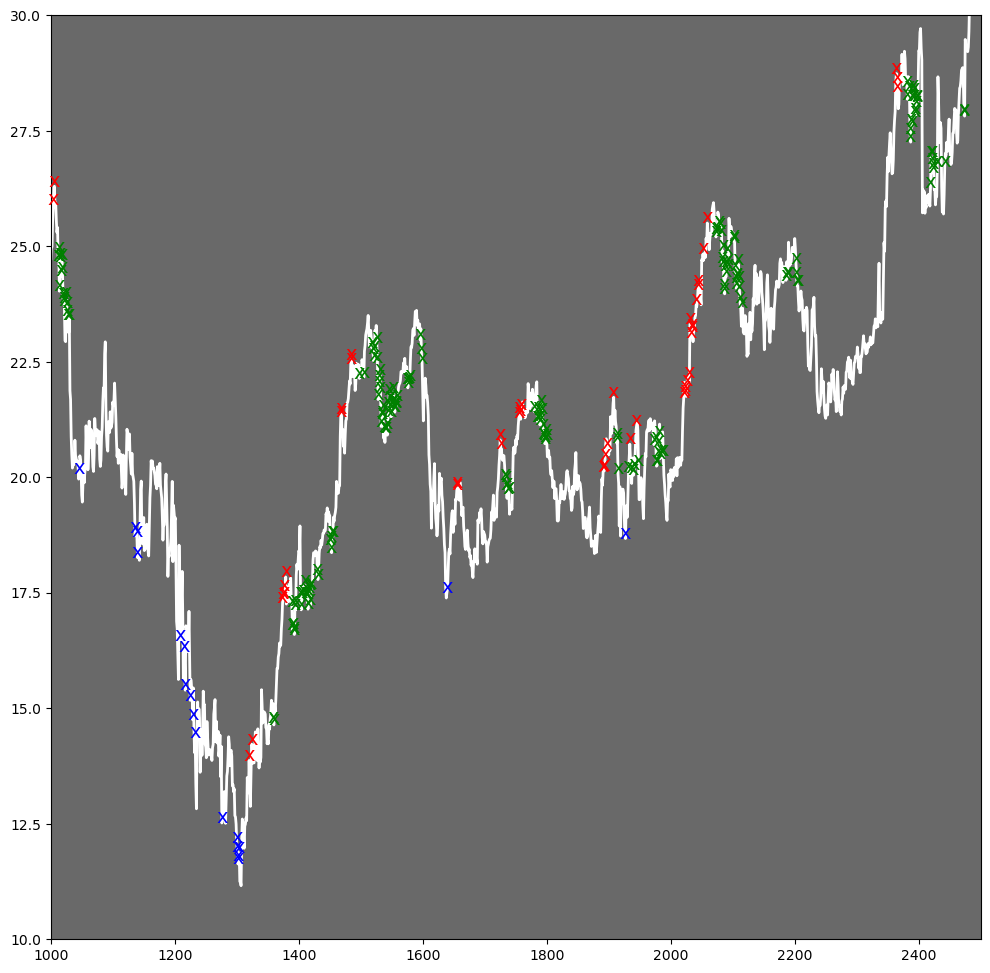

In [232]:
a = pd.DataFrame(data["price_state"], columns = ["State"]) 
# state 0 = accurately priced?
# state 1 = increase
# state 2 = leadup to correction?

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

# Price plot
ax1.set_facecolor('dimgrey')
ax1.plot(data.index, data['Close'], linewidth = 2, color = "white")

# below
up = b_s
long_signal_dates = up.index
for date in long_signal_dates:
    ax1.annotate('x', xy=(date, data.iloc[date, 3]), color='blue', fontsize=14, ha='center', alpha = 1)
    

# above   
up = c_s
long_signal_dates = up.index
for date in long_signal_dates:
    ax1.annotate('x', xy=(date, data.iloc[date, 3]), color='red', fontsize=14, ha='center', alpha = 1)


# correctly priced
up = data["price_state"][data["price_state"] == 2]
long_signal_dates = up.index
for date in long_signal_dates:
    ax1.annotate('x', xy=(date, data.iloc[date, 3]), color='green', fontsize=14, ha='center', alpha = 1)

plt.xlim(1000,2500)
plt.ylim(10,30)
plt.show()

In [228]:
val = 100
k = 75
inventory = 0
for i in range(len(data)):
    
    
    if i in b_s.index and val >= k: # buy?
        val = val - k
        inventory = inventory + k/data["Close"][i]
        
    #elif i in d.index and val >= 0 and val < 50:
        #val = val - k
        #inventory = inventory + k/data["Close"][i]
        
    elif i in c_s.index and inventory > 0: # sell?
        val = val + inventory * data["Close"][i]
        inventory = inventory * 0
    
    #elif i in d.index and val > 20:
        #val = val + 0.5*inventory * data["Close"][i]
        #inventory = inventory * 0.5
        
(val/100)**(252/len(data)) - 1

0.009114283744426688

In [94]:
a = 100/data["Close"][0]
b = a * data["Close"][len(data)-1]

(b/100)**(252/len(data)) - 1

0.17093848797825495